In [1]:
import xupy as xp
from numpy.ma import masked_array
import matplotlib.pyplot as plt

from arte.math.toccd import toccd

from ekarus.e2e.devices.pyramid_wfs import PyramidWFS
from ekarus.e2e.devices.detector import Detector
from ekarus.e2e.devices.slope_computer import SlopeComputer

from  ekarus.e2e.utils.image_utils import get_photocenter, showZoomCenter, get_circular_mask#, image_grid


[XuPy] Device 0 available - GPU : `NVIDIA GeForce RTX 4060 Laptop GPU`
       Memory = 7805.56 MB | Compute Capability = 8.9
       Using CuPy 13.5.1 for acceleration.


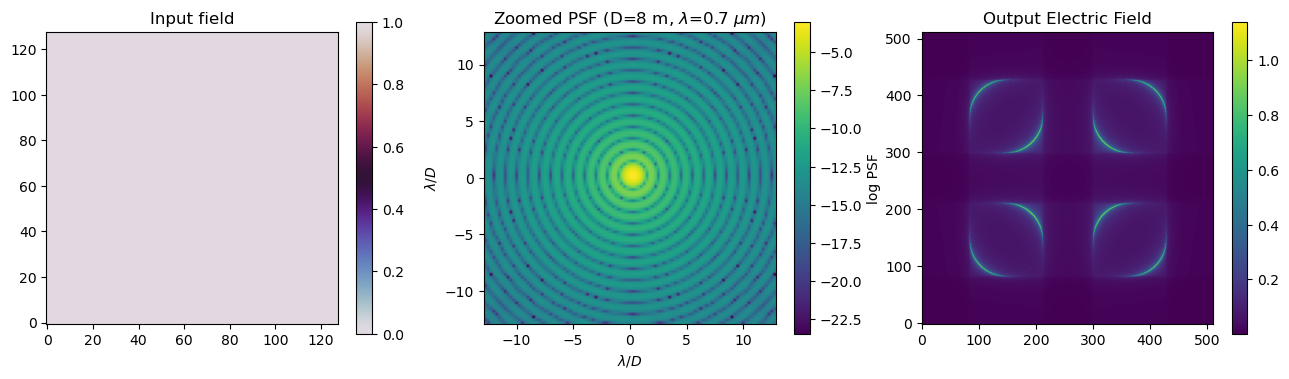

In [2]:
Npix = 128
mask = get_circular_mask((Npix,Npix),Npix//2)


# Conversions
oversampling = 4
pupilDiameterInM = 8
lambdaInM = 700e-9
lambdaOverD = lambdaInM/pupilDiameterInM

input_field = (1-mask).astype(float)

# Pyramid WFS
apex_angle = 108.2764*(2*xp.pi)*lambdaOverD
wfs = PyramidWFS(apex_angle, oversampling, sensorLambda=lambdaInM)

# Electric field propagation
padded_field = xp.pad(input_field, int((oversampling-1)/2*Npix), mode='constant', constant_values=0.0)
output_field = wfs.propagate(padded_field, lambdaOverD)
intensity = xp.abs(output_field**2)

# Compute normalized psf
psf = xp.abs(xp.abs(wfs.field_on_focal_plane**2))
psf *= 1/xp.sum(psf)

# Plotting results
s = 0.45
plt.figure(1, figsize=(16,9))
plt.subplot(1, 3, 1)
plt.title(f'Input field')
plt.imshow(xp.asnumpy(input_field), cmap='twilight', origin='lower')
plt.colorbar(shrink=s)

plt.subplot(1, 3, 2)
showZoomCenter(psf, 1/oversampling, title=r'Zoomed PSF (D=%g m, $\lambda$=%g $\mu m$)' % (pupilDiameterInM, lambdaInM*1e6),
               xlabel=r'$\lambda/D$', ylabel=r'$\lambda/D$',
               zlabel=r'log PSF', shrink=0.45)


plt.subplot(1, 3, 3)
plt.title("Output Electric Field")
plt.imshow(xp.asnumpy(intensity),origin='lower')
plt.colorbar(shrink=s)
plt.show()

Defining the detector subaperture masks ...
raw_intensity [2809 2809 2809 2809]
[[170.  69.]
 [170. 170.]
 [ 69.  69.]
 [ 69. 170.]]


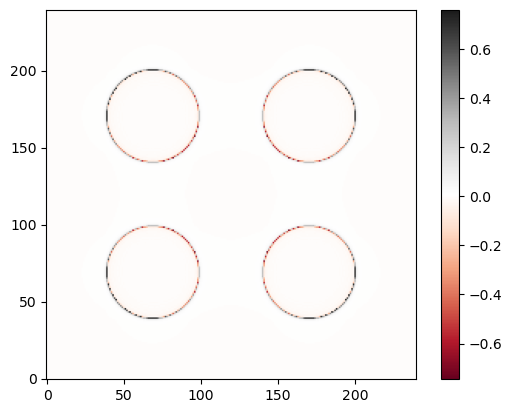

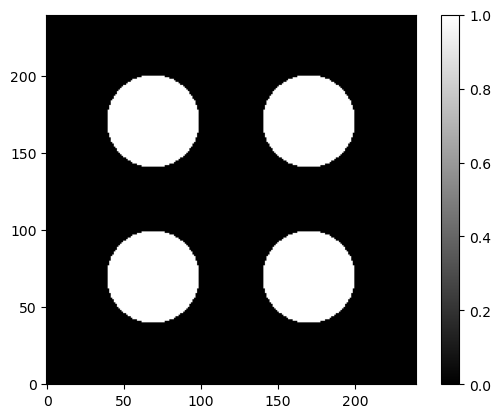

In [3]:
Ndet = 240
ccd = Detector(detector_shape=(Ndet,Ndet))

pars = {'modulationInLambdaOverD':3, 'slope_method': 'raw_intensity'}
sc = SlopeComputer(wfs, ccd, pars)
sc.calibrate_sensor(tn='test_wfs', prefix_str='', recompute=True, zero_phase=(1-mask).astype(float), lambdaOverD=lambdaOverD, Npix=Ndet/oversampling, centerObscurationInPixels=0.0)
subapertures = sc._roi_masks
roi_mask = xp.sum(1-subapertures,axis=0).astype(bool)

print(sc._slope_method,xp.sum(1-subapertures,axis=(1,2)))

frame = ccd.last_frame.copy()
frame /= xp.max(frame)
frame -= roi_mask.astype(float)

plt.figure()
plt.imshow(xp.asnumpy(frame), origin='lower',cmap='RdGy')
plt.colorbar()

plt.figure()
plt.imshow(xp.asnumpy(roi_mask), origin='lower',cmap='gray')
plt.colorbar()

print(sc._subap_centers)

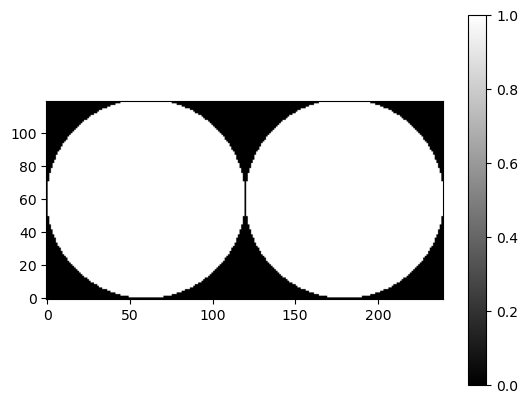

In [15]:
slopes_mask = xp.zeros([int(xp.ceil(Ndet/oversampling)*2),int(4*xp.ceil(Ndet/oversampling))])
slopex_mask = get_circular_mask(slopes_mask.shape,mask_radius=Ndet/oversampling,mask_center=(slopes_mask.shape[0]/2,slopes_mask.shape[0]/2))
slopey_mask = get_circular_mask(slopes_mask.shape,mask_radius=Ndet/oversampling,mask_center=(slopes_mask.shape[0]*3/2,slopes_mask.shape[0]/2))
slopes_mask += slopex_mask
slopes_mask += slopey_mask
slopes_mask = (slopes_mask<2).astype(bool)

plt.figure()
plt.imshow(xp.asnumpy(slopes_mask), origin='lower',cmap='gray')
plt.colorbar()